# Multi-Modal data comparison
This notebook analyzes other data and compares this with the eye blinking and neural results.

## Standard Deviation of the Lateral Position (SDLP)

In [179]:
import csv
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

sdlp_normal = []
sdlp_sleepy = []
kss3_normal = []
kss3_sleepy = []
labels = []

with open('../multi_modal_data/multi_modal_edited.csv', 'r') as file:
    reader = csv.reader(file)
    next(reader)
    for row in reader:
        if 'N' in row[0]:
            if row[0][:-1] == 20 or row[0][:-1] == 15:
                continue
            sdlp_normal.append(float(row[1].replace(',', '.')))
            kss3_normal.append(int(row[2]))
            labels.append(row[0][:-1])
        elif 'S' in row[0]:
            if row[0][:-1] == 20 or row[0][:-1] == 15:
                continue
            sdlp_sleepy.append(float(row[1].replace(',', '.')))
            kss3_sleepy.append(int(row[2]))
print(sdlp_normal)
print(sdlp_sleepy)
print(labels)
print(kss3_sleepy)

[14.32, 25.62, 13.8, 19.95, 18.66, 15.75, 23.02, 20.51, 12.64, 28.56, 20.61, 14.97, 16.77, 14.06]
[18.91, 25.36, 14.2, 20.07, 17.97, 18.8, 22.22, 18.55, 12.8, 22.69, 21.25, 19.48, 17.41, 22.88]
['1', '3', '4', '6', '7', '9', '10', '11', '12', '14', '15', '16', '20', '23']
[8, 9, 7, 3, 5, 0, 7, 2, 6, 8, 9, 0, 4, 0]


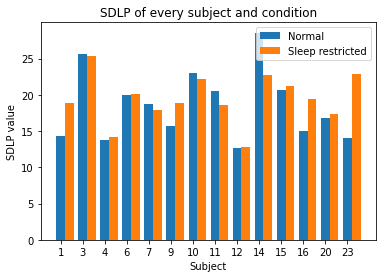

In [180]:
X_sdlp = np.arange(len(sdlp_normal))

plt.bar(X_sdlp , sdlp_normal, width = 0.4, label = 'Normal')
plt.bar(X_sdlp + 0.4, sdlp_sleepy, width = 0.4, label = 'Sleep restricted')
plt.legend()
plt.xticks(X_sdlp, labels)
plt.xlabel('Subject')
plt.ylabel('SDLP value')
plt.title('SDLP of every subject and condition')

plt.savefig('../final_figures/sdlp_per_subject.jpg')
plt.show()

### Change in SDLP between conditions
The change of SDLP taken from the sleepy condition. Where a positive value means a higher SDLP in the sleepy condition, and a negative value means a higher SDLP value in the normal condition.

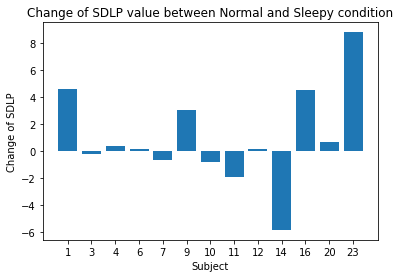

In [163]:
sdlp_change = np.array(sdlp_sleepy) - np.array(sdlp_normal)

plt.bar(X_sdlp, sdlp_change)
plt.xticks(X_sdlp, labels)
plt.xlabel('Subject')
plt.ylabel('Change of SDLP')
plt.title('Change of SDLP value between Normal and Sleepy condition')

plt.savefig('../final_figures/sdlp_change.jpg')
plt.show()

## Karolinska Sleepiness Scale (KSS)
Analyzing and comparing with the KSS scores, appointed during the turning point after half an hour of driving.

In [53]:
# First we have to remove the zero values of subject 9,16 and 23, as these subjects only include SDLP data
kss_labels = labels.copy()
kss_labels.remove('9')
kss_labels.remove('16')
kss_labels.remove('23')
kss3_normal.remove(0)
kss3_sleepy.remove(0)
kss3_normal.remove(0)
kss3_sleepy.remove(0)
kss3_normal.remove(0)
kss3_sleepy.remove(0)

# Check if the lengths of the lists are equivalent
print(len(kss_labels), len(kss3_normal), len(kss3_sleepy))

11 11 11


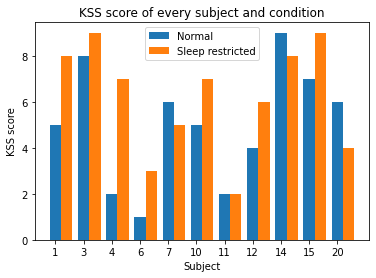

In [54]:
X = np.arange(len(kss3_normal))

plt.bar(X , kss3_normal, width = 0.4, label = 'Normal')
plt.bar(X + 0.4, kss3_sleepy, width = 0.4, label = 'Sleep restricted')
plt.legend()
plt.xticks(X, kss_labels)
plt.xlabel('Subject')
plt.ylabel('KSS score')
plt.title('KSS score of every subject and condition')

plt.savefig('../final_figures/kss_per_subject.jpg')
plt.show()



In [55]:
def analyze_kss(normal_scores, sleepy_scores, labels):
    change = np.array(sleepy_scores) - np.array(normal_scores)
    sleep_effect = np.where(change > 0)[0]
    no_effect = np.where(change <= 0)[0]
    
    effect_subjects = [labels[i] for i in sleep_effect]
    no_effect_subjects = [labels[i] for i in no_effect]
    
    print("Subjects where sleepy condition is more sleepy: ")
    print(effect_subjects)
    print("Subjects where sleepy condition is NOT more sleepy: ")
    print(no_effect_subjects)
    
analyze_kss(kss3_normal, kss3_sleepy, kss_labels)

Subjects where sleepy condition is more sleepy: 
['1', '3', '4', '6', '10', '12', '15']
Subjects where sleepy condition is NOT more sleepy: 
['7', '11', '14', '20']


## Shallow mean distance
To be able to compare the shallow features with the sdlp values, the distance between the means of each condition is calculated for every subject. Because with these distance values I can make a comparison, otherwise I cannot compare a bunch of segment points with one sdlp difference value.

In [28]:
# first lets load the shallow features
from helping_functions import *

def get_data(subject, treshhold, segment_length):
    status_rates_sleepy, wrong_frames_sleepy = load_blinks(subject, 'sleepy') 

    status_rates_normal, wrong_frames_normal = load_blinks(subject, 'normal') 
    print("Starting segmenting normal condition")
    blink_counts_normal, average_durs_normal = run_analysis(status_rates_normal, wrong_frames_normal, treshhold, segment_length)

    print("Starting segmenting sleepy condition")
    blink_counts_sleepy, average_durs_sleepy = run_analysis(status_rates_sleepy, wrong_frames_sleepy, treshhold, segment_length)

    return list(zip(blink_counts_normal, average_durs_normal)), list(zip(blink_counts_sleepy, average_durs_sleepy))

subject = 'subject1'
minutes = 1
threshold = 10
segment_length = int(2760 * minutes)

X_normal, X_sleepy = get_data(subject, threshold, segment_length)

Starting segmenting normal condition
Number of segments 58
Starting segmenting sleepy condition
Number of segments 53


In [43]:
def get_mean_distance(X_normal, X_sleepy, normalization):
    if normalization:
        # first normalization over all points in range 0-1 - minmax scaler
        X = X_normal + X_sleepy
        scaler = MinMaxScaler()
        X_norm = scaler.fit_transform(X)
        X_normal = X_norm[:len(X_normal)]
        X_sleepy = X_norm[:len(X_sleepy)]

    # calcualtion of the mans for both condition
    mean_normal = np.mean(X_normal, axis=0)
    mean_sleepy = np.mean(X_sleepy, axis=0)

    # then the euclidean distance between these two means is calculated
    distance = math.dist(mean_normal, mean_sleepy)
    return distance

distance = get_mean_distance(X_normal, X_sleepy, normalization = True)
print(distance)

0.0022189831896930585


In [178]:
def get_dis_multi_subs(subjects, treshold, segment_length, normalization):
    distances = []
    for sub in subjects:
        subject = 'subject' + str(sub)
        print(subject)
        X_normal, X_sleepy = get_data(subject, threshold, segment_length)
        distance = get_mean_distance(X_normal, X_sleepy, normalization)
        distances.append(distance)
    return distances

subjects = [1,3,4,6,7,9,10,11,12,14,15,16,20,23]

treshold = 10
minutes = 1
segment_length = int(2760 * minutes)

distances = get_dis_multi_subs(subjects, treshold, segment_length, normalization= False)

subject1
Starting segmenting normal condition
Number of segments 58
Starting segmenting sleepy condition
Number of segments 53
subject3
Starting segmenting normal condition
Number of segments 54
Starting segmenting sleepy condition
Number of segments 27
subject4
Starting segmenting normal condition
Number of segments 47
Starting segmenting sleepy condition
Number of segments 58
subject6
Starting segmenting normal condition
Number of segments 46
Starting segmenting sleepy condition
Number of segments 58
subject7
Starting segmenting normal condition
Number of segments 46
Starting segmenting sleepy condition
Number of segments 58
subject9
Starting segmenting normal condition
Number of segments 11
Starting segmenting sleepy condition
Number of segments 15
subject10
Starting segmenting normal condition
Number of segments 44
Starting segmenting sleepy condition
Number of segments 55
subject11
Starting segmenting normal condition
Number of segments 70
Starting segmenting sleepy condition
Numb

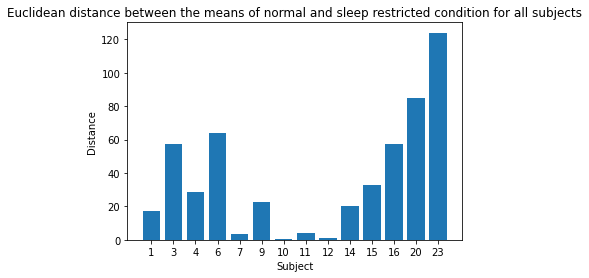

In [181]:
plt.bar(list(map(str, subjects)), list(np.array(distances)))
plt.xlabel('Subject')
plt.ylabel('Distance')
plt.title('Euclidean distance between the means of normal and sleep restricted condition for all subjects')

plt.savefig('../final_figures/mean_dist.jpg')
plt.show()

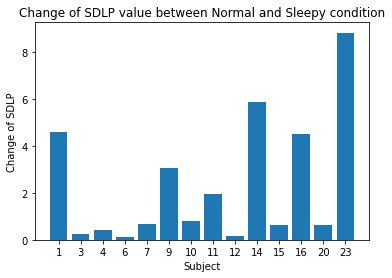

In [182]:
# plot sdlp change of absolute values
sdlp_change = np.array(sdlp_sleepy) - np.array(sdlp_normal)
sdlp_change = np.absolute(sdlp_change)

plt.bar(X_sdlp, sdlp_change)
plt.xticks(X_sdlp, labels)
plt.xlabel('Subject')
plt.ylabel('Change of SDLP')
plt.title('Change of SDLP value between Normal and Sleepy condition')

plt.savefig('../final_figures/sdlp_change.jpg')
plt.show()

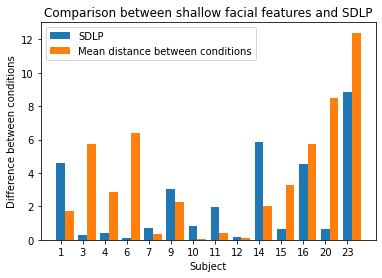

In [188]:
plt.bar(X_sdlp , sdlp_change , width = 0.4, label = 'SDLP')
plt.bar(X_sdlp + 0.4, list(np.array(distances)* 0.10 ), width = 0.4, label = 'Mean distance between conditions')
plt.legend()
plt.xticks(X_sdlp, labels)
plt.xlabel('Subject')
plt.ylabel('Difference between conditions')
plt.title('Comparison between shallow facial features and SDLP')

plt.savefig('../final_figures/sdlp_dist_comparison.jpg')
plt.show()


In [186]:
from scipy.stats import pearsonr
pearsonr(sdlp_change, np.array(distances) * 0.10)

(0.42216109500743454, 0.13267077756790094)